<a href="https://colab.research.google.com/github/JasmineAdvanture/fatty-liver-project/blob/BDS-11/Fatty_Liver_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import files
uploaded = files.upload()

Saving NTCMRC_all.xlsx to NTCMRC_all.xlsx


In [7]:
#Imports
import pandas as pd
import numpy as np

In [8]:
#read dataset as df
df = pd.read_excel("NTCMRC_all.xlsx")
df.head(5)


,sid,P_Number,birth,data_exam,CMRC_id,sex,age,data_year,year_come,height_y,...,"腎結節 ( yes=1, no=0)","左腎 (無:0, 單一:1,多發:2).3",公分.23,"右腎 (無:0, 單一:1,多發:2).3",公分.24,脾臟 (0:正常;1:脾臟腫大；2脾臟切除),spleen long axis (cm),spleen short axis (cm),脾面積(大於20CM=脾腫大),other
0,M11A011,M11A011,391127,20221122,R8M080Y5005M5,0,71,2022,2,145.2,...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
1,20221119122,P111782,410428,20221119,E42018P21120K8045,0,70,2022,3,153.5,...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
2,20221119121,P111781,401120,20221119,H62016G10710R5042,0,70,2022,5,147.5,...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
3,20221119120,P111780,430325,20221119,U32016A80710B9013,0,68,2022,4,148,...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
4,20221119119,P111779,390220,20221119,A72018S91120Z2060,1,72,2022,3,157,...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N


# 新段落

Data Type Conversion

In [9]:
# Create a copy of df as df1
df1 = df.copy()

# Replace '\\N' with NaN
df1 = df1.replace('\\N', np.nan)

# Specify the columns to be converted to float
columns_to_convert1 = ['BMI', 'Triglyceride_y', 'gamgt', 'waist_y', 'mst', 'egfrn', 'Estimated_GFR_x', 'Alb_Cre_ratio', 'HOMA_IR', 'HS_CRP', \
                       'LDL_C_direct', 'LDL_C_HDL_C', 'Adiponectin', 'Leptin', 'Uric_Acid','Insulin']

# Specify the columns to be converted to int
columns_to_convert2 = ['脂肪肝 fatty Liver (0:正常  1:mild 2:moderate 3:severe)', 'smoke', 'smoke_q']


# Convert the specified columns to float and fill missing/unconvertible values with NaN
for column in columns_to_convert1:
    df1[column] = pd.to_numeric(df1[column], errors='coerce')

# Convert the specified columns to int and fill missing/unconvertible values with NaN
for column in columns_to_convert2:
    df1[column] = pd.to_numeric(df1[column], errors='coerce').astype(float).astype(pd.Int64Dtype())

In [10]:
#Data Type Checks
column_list = ['脂肪肝 fatty Liver (0:正常  1:mild 2:moderate 3:severe)', 'BMI', 'Triglyceride_y', 'gamgt', 'waist_y', 'mst', 'egfrn', 'Estimated_GFR_x', 'Alb_Cre_ratio', 'HOMA_IR', 'HS_CRP',               'LDL_C_direct', 'LDL_C_HDL_C', 'Adiponectin', 'Leptin', 'Uric_Acid','Insulin', 'smoke', 'smoke_q']
data_types = df1[column_list].dtypes
print(data_types)


脂肪肝 fatty Liver (0:正常  1:mild 2:moderate 3:severe)      Int64
BMI                                                   float64
Triglyceride_y                                        float64
gamgt                                                 float64
waist_y                                               float64
mst                                                     int64
egfrn                                                 float64
Estimated_GFR_x                                       float64
Alb_Cre_ratio                                         float64
HOMA_IR                                               float64
HS_CRP                                                float64
LDL_C_direct                                          float64
LDL_C_HDL_C                                           float64
Adiponectin                                           float64
Leptin                                                float64
Uric_Acid                                             float64
Insulin 

Derive Target Variables

In [11]:
# Calculate FLI using the formula and defined as df2
df2 = df1.copy()
df2['FLI'] = (np.exp(0.953 * np.log(df2['Triglyceride_y']) + 0.139 * df2['BMI'] + 0.718 * np.log(df2['gamgt']) \
     + 0.053 * df2['waist_y'] - 15.745)) / (1 + np.exp(0.953 * np.log(df2['Triglyceride_y']) \
    + 0.139 * df2['BMI'] + 0.718 * np.log(df2['gamgt']) + 0.053 * df2['waist_y'] - 15.745)) * 100

# Derive FL_echo based on ultrasound results column
df2['FL_echo'] = df2['脂肪肝 fatty Liver (0:正常  1:mild 2:moderate 3:severe)']
df2['FL_echo'] = df2['FL_echo'].replace('<NA>', np.nan)

#Derive fl_status column based on fl_echo and FLI(when available): 1 for positive; 0 for negative; -1 for unavailable
def derive_fl_status(row):
    # Derive FL_Check column to infer the status by echo or FLI
    liver_status = row['脂肪肝 fatty Liver (0:正常  1:mild 2:moderate 3:severe)']
    fli_value = row['FLI']

    if pd.isna(liver_status) and pd.isna(fli_value):
        return -1
    elif pd.notna(liver_status) and liver_status != 0:
        return 1
    elif pd.notna(fli_value) and fli_value >= 60:
        return 1
    else:
        return 0

df2['fl_status'] = df2.apply(derive_fl_status, axis=1)

#Derive homa_ir_check, hs_crp_check, and mst_total to determine MAFLD risk factors
df2['homa_ir_check'] = df2['HOMA_IR'].apply(lambda x: 1 if x >= 2.5 else 0)
df2['hs_crp_check'] = df2['HS_CRP'].apply(lambda x: 1 if x > 2 else 0)
df2['mst_total'] = df2[['w', 'hyper', 'HDL', 'fg', 'trig', 'homa_ir_check', 'hs_crp_check']].sum(axis=1)

In [12]:
#Derive target variables and named as df3
def derive_MAFLD(df):
    df['MAFLD'] = 0  # Initialize MAFLD field as 0

    # Condition 1: fl_status = -1
    df.loc[df['fl_status'] == -1, 'MAFLD'] = -1

    # Condition 2: fl_check = 0
    df.loc[df['fl_status'] == 0, 'MAFLD'] = 0

    # Condition 3: fl_check = 1
    # Subcondition 1: BMI >= 23
    df.loc[(df['fl_status'] == 1) & (df['BMI'] >= 23), 'MAFLD'] = 1

    # Subcondition 2: BMI < 23 and mst >= 2
    df.loc[(df['fl_status'] == 1) & (df['BMI'] < 23) & (df['mst_total'] >= 2), 'MAFLD'] = 1

    # Subcondition 3: DM_determine = 1
    df.loc[(df['fl_status'] == 1) & (df['DM_determine'] == 1), 'MAFLD'] = 1

    return df

def derive_CKD(df):
    # Initialize CKD field as -1
    df['CKD'] = -1

    # Condition 1: egfrn >= 60 and Alb_Cre_ratio < 3
    df.loc[(df['Estimated_GFR_x'] >= 60) & (df['Alb_Cre_ratio'] < 3), 'CKD'] = 1

    # Condition 2: egfrn >= 60 and 3 <= Alb_Cre_ratio <= 30 or 45 <= egfrn < 60 and Alb_Cre_ratio < 3
    df.loc[((df['Estimated_GFR_x'] >= 60) & (df['Alb_Cre_ratio'].between(3, 30))) |
           ((df['Estimated_GFR_x'].between(45, 60)) & (df['Alb_Cre_ratio'] < 3)), 'CKD'] = 2

    # Condition 3: egfrn >= 60 and Alb_Cre_ratio > 30 or egfrn < 60 and Alb_Cre_ratio >= 0
    df.loc[((df['Estimated_GFR_x'] >= 60) & (df['Alb_Cre_ratio'] > 30)) |
           ((df['Estimated_GFR_x'] < 60) & (df['Alb_Cre_ratio'] >= 0)), 'CKD'] = 3

    # Set CKD as 0 for cases where egfrn and Alb_Cre_ratio are not empty and CKD is still -1
    df.loc[(df['Estimated_GFR_x'].notnull()) & (df['Alb_Cre_ratio'].notnull()) & (df['CKD'] == -1), 'CKD'] = 0

    return df

df3 = derive_CKD(derive_MAFLD(df2))

Derive Patient MAFLD Validity Status in complete, partial and unvailable

In [13]:
# Derive FL_group_list, 对CMRC_id分组并计算每个病人的FL_Check的唯一值
grouped = df2.groupby('CMRC_id')['fl_status'].unique()
df2['fl_group_list'] = df2.groupby('CMRC_id')['fl_status'].transform(lambda x: [x.unique().tolist()] * len(x))

# Derive patient_fl_validity according to FL_group_list conditions
def assign_patient_fl_validity(df):
    df['patient_fl_validity'] = -1  # 初始化所有记录为第三组 (-1)

    def get_patient_valid(group_list):
        if isinstance(group_list, list):
            if -1 in group_list and len(group_list) == 1:
                return "unavailable"  # 第三组 (-1)
            elif -1 in group_list:
                return "partial"  # 第二组 (0)
            else:
                return "completed"  # 第一组 (1)
        else:
            return "others"  # 第三组 (-1)

    df['patient_fl_validity'] = df['fl_group_list'].apply(get_patient_valid)

    return df


#assign patient valid value
df4 = assign_patient_fl_validity(df3)

In [14]:
# Checks for patient fatty liver validity status
df4['patient_fl_validity'].value_counts()

completed      21749
partial          602
unavailable      483
Name: patient_fl_validity, dtype: int64

Grouping data in the patient level and using sliding window for predictions

In [15]:
def sliding_window_data(df, input_window_size, target_window_size):
    transformed_data = []
    group_counter = {}

    df_sorted = df.sort_values(['CMRC_id', 'year_come'])

    for patient_id, group in df_sorted.groupby('CMRC_id'):
        if len(group) < input_window_size + target_window_size:
            continue


        group_counter.setdefault(patient_id, 0)
        group_counter[patient_id] += 1
        group_alias = f'{patient_id}_group{group_counter[patient_id]}'

        for i in range(len(group) - input_window_size - target_window_size + 1):
            input_data = group[i:i+input_window_size]
            target_data = group[i+input_window_size:i+input_window_size+target_window_size]

            # Flatten input_data and repeat target_data
            input_features_t1 = input_data.iloc[0, :].values.flatten()
            input_features_t2 = input_data.iloc[1, :].values.flatten()
            t3_MAFLD = target_data['MAFLD'].values

            new_row = [group_alias] + list(input_features_t1) + list(input_features_t2) + list(t3_MAFLD)

            transformed_data.append(new_row)

    columns_list = ['CMRC_id'] + [f't1_{col}' for col in input_data.columns] + [f't2_{col}' for col in input_data.columns] + [f't3_MAFLD']
    transformed_df = pd.DataFrame(transformed_data, columns=columns_list)
    return transformed_df


# Sliding window implementation, ie. use previous 2 years record to predict the 3 year MAFLD status
df5 = sliding_window_data(df4, input_window_size=2, target_window_size=1)


In [16]:
pd.set_option('display.max_columns', None)
df5.head(5)

CMRC_id       t1_sid t1_P_Number  t1_birth  t1_data_exam  \
0  A02013O51207P5052_group1  20131207052     P020859    430127      20131207   
1  A02013O51207P5052_group1  20141220048     P032306    430127      20141220   
2  A02013O51207P5052_group1  20160409051     P050743    430127      20160409   
3  A02013O51207P5052_group1  20170429016     P060991    430127      20170429   
4  A02014I70719D9059_group1  20140719059     P031204    450628      20140719   

          t1_CMRC_id  t1_sex  t1_age  t1_data_year  t1_year_come  t1_height_y  \
0  A02013O51207P5052       0      59          2013             1        148.0   
1  A02013O51207P5052       0      60          2014             2        149.0   
2  A02013O51207P5052       0      62          2016             3        147.0   
3  A02013O51207P5052       0      63          2017             4        148.0   
4  A02014I70719D9059       0      58          2014             1        146.0   

   t1_weight_y  t1_waist_y  t1_systolic_y  t1_diastolic_y  t1_heartbeat_y  \
0         70.0        82.0          134.0            81.0            89.0   
1         71.0        83.0          141.0            74.0            82.0   
2         71.3        85.0          116.0            67.0            82.0   
3         71.9        84.0          131.0            77.0            88.0   
4         44.0        61.0          149.0            96.0            91.0   

   t1_arm_circumference  t1_calf_circumference  t1_Thigh_circumference  \
0                   NaN                    NaN                     NaN   
1                   NaN                    NaN                     NaN   
2                   NaN                    NaN                     NaN   
3                   NaN                    NaN                     NaN   
4                   NaN                    NaN                     NaN   

   t1_Glucose_AC_y  t1_Triglyceride_y  t1_HDL_C_y  t1_WBCb  t1_RBCb  \
0            101.0              264.0        56.4      5.8     4.48   
1            104.0              255.0        55.8      5.0     4.44   
2            103.0              192.0        60.7      6.2     4.63   
3            111.0              164.0        83.0      5.4     4.36   
4             99.0               75.0        60.4      4.2     4.87   

   t1_Hemoglobin  t1_Hematocrit  t1_MCV  t1_MCH  t1_MCHC  t1_RDW  \
0           13.7           41.2    92.0    30.6     33.3    12.7   
1           13.4           40.3    90.8    30.2     33.3    12.4   
2           14.1           42.9    92.7    30.5     32.9    12.8   
3           13.1           39.9    91.5    30.0     32.8    12.7   
4           13.8           42.6    87.5    28.3     32.4    12.8   

   t1_Platelets  t1_Transferrin  t1_Ferritin t1_Folate  t1_AST_GOT  \
0         191.0           242.9         52.1     14.16        21.0   
1         190.0             NaN          NaN       NaN        15.0   
2         193.0           262.0         62.1     12.41        18.0   
3         218.0             NaN          NaN       NaN        27.0   
4         268.0           240.9         94.6     19.34        23.0   

   t1_ALT_GPT  t1_ALK_P t1_Total_Bilirubin t1_D_Bilirubin  t1_gamgt t1_AFP  \
0        19.0      57.0                0.7            0.1      15.0    2.8   
1        18.0      55.0                0.5            0.1      14.0    2.6   
2        22.0      50.0                0.7          < 0.1      17.0    4.1   
3        30.0      46.0                0.4            0.1      16.0    3.9   
4        17.0      90.0                0.8            0.1      10.0    3.3   

   t1_Insulin  t1_T_Cholesterol  t1_LDL_C_direct  t1_VLDL_C  t1_Non_HDL_C  \
0        9.18             315.0            196.5       53.0         259.0   
1        5.86             312.0            199.0       51.0         256.0   
2        4.56             213.0            115.0       38.0         152.0   
3        6.30             267.0            157.6       33.0         184.0   
4        3.75             198.0  

In [17]:
#Checks
filtered_data = df5[(df5['t1_MAFLD'] != -1) & (df5['t2_MAFLD'] != -1) & (df5['t3_MAFLD'] != -1)]
value_counts = filtered_data['t2_patient_fl_validity'].value_counts()
print(value_counts)

completed    9386
partial       168
Name: t2_patient_fl_validity, dtype: int64


Conventional Machine Learning Models

In [18]:
# Filter available data that can be applied to models
df6 = df5[(df5['t1_MAFLD'] != -1) & (df5['t2_MAFLD'] != -1) & (df5['t3_MAFLD'] != -1) & (df5['t1_patient_fl_validity'] == 'completed')]

# # Replace '\\N' with NaN
# df6 = df6.replace('\\N', np.nan)

# Drop ID relevant cols in the dataset
columns_to_drop = ['CMRC_id', 't1_CMRC_id', 't2_CMRC_id', 't1_sid', 't2_sid', 't1_P_Number','t2_P_Number']
df7 = df6.drop(columns=columns_to_drop)



In [19]:
#Select key columns for conventional machine learning models

# This function is for adding prefix for cols, the cols should be a list of column names that needs to add prefix(such as "t1_" in this project)
def add_prefix(cols, prefixes):
# Note the prefixes should be a LIST, eg. prefixes = ["t1_", "t2_"]
    renamed_columns = []
    for prefix in prefixes:
        renamed_columns.extend([prefix + column for column in cols])
    return renamed_columns

columns = ["sex", "age", "waist_y", "Glucose_AC_y", "Triglyceride_y", "HDL_C_y", "AST_GOT", "ALT_GPT", \
          "gamgt", "Insulin", "T_Cholesterol", "LDL_C_direct", "VLDL_C", "Non_HDL_C", "T_CHOL_HDL_C", \
          "LDL_C_HDL_C", "HS_CRP", "Hb_A1c", "Uric_Acid", "HBsAg_x", "Anti_HCV_x", "HOMA_IR", "Adiponectin", \
           "Leptin", "TotalVitaminD", "smoke", "smoke_q", "coffee", "betel", "BMI", "DM_determine", "w", "hyper", \
           "fg", "HDL", "trig", "sarcf", "ms2", "MNA", "AUDIT", "HBV_", "HCV_", "MAFLD", "CKD"]
prefixes = ["t1_", "t2_"]
renamed_columns = add_prefix(columns, prefixes)
print(renamed_columns)



['t1_sex', 't1_age', 't1_waist_y', 't1_Glucose_AC_y', 't1_Triglyceride_y', 't1_HDL_C_y', 't1_AST_GOT', 't1_ALT_GPT', 't1_gamgt', 't1_Insulin', 't1_T_Cholesterol', 't1_LDL_C_direct', 't1_VLDL_C', 't1_Non_HDL_C', 't1_T_CHOL_HDL_C', 't1_LDL_C_HDL_C', 't1_HS_CRP', 't1_Hb_A1c', 't1_Uric_Acid', 't1_HBsAg_x', 't1_Anti_HCV_x', 't1_HOMA_IR', 't1_Adiponectin', 't1_Leptin', 't1_TotalVitaminD', 't1_smoke', 't1_smoke_q', 't1_coffee', 't1_betel', 't1_BMI', 't1_DM_determine', 't1_w', 't1_hyper', 't1_fg', 't1_HDL', 't1_trig', 't1_sarcf', 't1_ms2', 't1_MNA', 't1_AUDIT', 't1_HBV_', 't1_HCV_', 't1_MAFLD', 't1_CKD', 't2_sex', 't2_age', 't2_waist_y', 't2_Glucose_AC_y', 't2_Triglyceride_y', 't2_HDL_C_y', 't2_AST_GOT', 't2_ALT_GPT', 't2_gamgt', 't2_Insulin', 't2_T_Cholesterol', 't2_LDL_C_direct', 't2_VLDL_C', 't2_Non_HDL_C', 't2_T_CHOL_HDL_C', 't2_LDL_C_HDL_C', 't2_HS_CRP', 't2_Hb_A1c', 't2_Uric_Acid', 't2_HBsAg_x', 't2_Anti_HCV_x', 't2_HOMA_IR', 't2_Adiponectin', 't2_Leptin', 't2_TotalVitaminD', 't2_smoke',

In [22]:
df8 = df7[renamed_columns]
df8['t3_MAFLD'] = df7['t3_MAFLD']

pd.set_option('display.max_rows', None)
print(df8.dtypes)

t1_sex                 int64
t1_age                 int64
t1_waist_y           float64
t1_Glucose_AC_y      float64
t1_Triglyceride_y    float64
t1_HDL_C_y           float64
t1_AST_GOT           float64
t1_ALT_GPT           float64
t1_gamgt             float64
t1_Insulin           float64
t1_T_Cholesterol     float64
t1_LDL_C_direct      float64
t1_VLDL_C            float64
t1_Non_HDL_C         float64
t1_T_CHOL_HDL_C      float64
t1_LDL_C_HDL_C       float64
t1_HS_CRP            float64
t1_Hb_A1c            float64
t1_Uric_Acid         float64
t1_HBsAg_x            object
t1_Anti_HCV_x         object
t1_HOMA_IR           float64
t1_Adiponectin       float64
t1_Leptin            float64
t1_TotalVitaminD     float64
t1_smoke              object
t1_smoke_q            object
t1_coffee            float64
t1_betel             float64
t1_BMI               float64
t1_DM_determine        int64
t1_w                   int64
t1_hyper               int64
t1_fg                  int64
t1_HDL        

<ipython-input-22-9815cc9098cc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df8['t3_MAFLD'] = df7['t3_MAFLD']


In [ ]:
##cols t1_LDL_C_direct, t1_LDL_C_HDL_C, t2_Insulin to float
# t1_Adiponectin, t1_Leptin, t1_Uric_Acid to float
# t1_smoke, t2_smoke_q, to int
fields = ['t1_Adiponectin', 't1_Leptin', 't1_Uric_Acid','t1_smoke', 't2_smoke_q']

for field in fields:
    counts = df8[field].value_counts(dropna=False)
    print(f"{field} value counts:")
    print(counts)
    print()

In [24]:
# Deal with HBsAg_x, Anti_HCV_x, (values eg. 陰性    0.351)
# This function will extract the numeric values
import re
def extract_numeric_value(value):
    pattern = r'\d+(\.\d+)?'  # 正则表达式模式，匹配一个或多个数字（包括小数点）
    match = re.search(pattern, str(value))
    if match:
        return float(match.group())
    else:
        return None

# extract numeric values for these cols and rename that as  *_num
columns_to_extract = ['t1_HBsAg_x', 't2_HBsAg_x', 't1_Anti_HCV_x', 't2_Anti_HCV_x']

df9 = df8.copy()
for column in columns_to_extract:
    new_column_name = column + '_num'
    df9[new_column_name] = df9[column].apply(extract_numeric_value)

# 检查结果
df9[columns_to_extract + [column + '_num' for column in columns_to_extract]].head(10)


,t1_HBsAg_x,t2_HBsAg_x,t1_Anti_HCV_x,t2_Anti_HCV_x,t1_HBsAg_x_num,t2_HBsAg_x_num,t1_Anti_HCV_x_num,t2_Anti_HCV_x_num
0,Nonreactive 0.44,NaN,Nonreactive 0.040,NaN,0.44,NaN,0.04,NaN
1,NaN,Nonreactive 0.48,NaN,Nonreactive 0.030,NaN,0.480,NaN,0.030
2,Nonreactive 0.48,NaN,Nonreactive 0.030,NaN,0.48,NaN,0.03,NaN
3,NaN,Nonreactive 0.33,NaN,Nonreactive 0.036,NaN,0.330,NaN,0.036
4,Nonreactive 0.38,NaN,Nonreactive 0.040,NaN,0.38,NaN,0.04,NaN
5,NaN,Nonreactive 0.52,NaN,Nonreactive 0.030,NaN,0.520,NaN,0.030
6,Nonreactive 0.52,NaN,Nonreactive 0.030,NaN,0.52,NaN,0.03,NaN
7,NaN,Nonreactive 0.695,NaN,Nonreactive 0.040,NaN,0.695,NaN,0.040
8,Nonreactive 0.44,NaN,Nonreactive 0.040,NaN,0.44,NaN,0.04,NaN
9,Nonreactive 0.34,NaN,Nonreactive 0.030,NaN,0.34,NaN,0.03,NaN


In [25]:
# Specify the columns to be converted to float
columns_to_convert1 = ['t1_LDL_C_direct', 't1_LDL_C_HDL_C', 't1_Adiponectin', 't1_Leptin', 't1_Uric_Acid','t1_Insulin', \
                       't2_LDL_C_direct', 't2_LDL_C_HDL_C', 't2_Adiponectin', 't2_Leptin', 't2_Uric_Acid','t2_Insulin',]

# Specify the columns to be converted to int
columns_to_convert2 = ['t1_smoke', 't1_smoke_q', 't2_smoke', 't2_smoke_q']

# Convert the specified columns to float and fill missing/unconvertible values with NaN
for column in columns_to_convert1:
    df9[column] = pd.to_numeric(df9[column], errors='coerce')

# Convert the specified columns to int and fill missing/unconvertible values with NaN
for column in columns_to_convert2:
    df9[column] = pd.to_numeric(df9[column], errors='coerce').astype(float).astype(pd.Int64Dtype())

In [26]:
# check stats
df9['t3_MAFLD'].value_counts(dropna=False)

0    7423
1    1963
Name: t3_MAFLD, dtype: int64

In [27]:
# drop these cols as those been derived for numeric cols, alias *_num
cols_to_drop = ['t1_HBsAg_x', 't2_HBsAg_x', 't1_Anti_HCV_x', 't2_Anti_HCV_x']
df9 = df9.drop(cols_to_drop, axis=1)

#check data types
pd.set_option('display.max_rows', None)
print(df9.dtypes)

t1_sex                 int64
t1_age                 int64
t1_waist_y           float64
t1_Glucose_AC_y      float64
t1_Triglyceride_y    float64
t1_HDL_C_y           float64
t1_AST_GOT           float64
t1_ALT_GPT           float64
t1_gamgt             float64
t1_Insulin           float64
t1_T_Cholesterol     float64
t1_LDL_C_direct      float64
t1_VLDL_C            float64
t1_Non_HDL_C         float64
t1_T_CHOL_HDL_C      float64
t1_LDL_C_HDL_C       float64
t1_HS_CRP            float64
t1_Hb_A1c            float64
t1_Uric_Acid         float64
t1_HOMA_IR           float64
t1_Adiponectin       float64
t1_Leptin            float64
t1_TotalVitaminD     float64
t1_smoke               Int64
t1_smoke_q             Int64
t1_coffee            float64
t1_betel             float64
t1_BMI               float64
t1_DM_determine        int64
t1_w                   int64
t1_hyper               int64
t1_fg                  int64
t1_HDL                 int64
t1_trig                int64
t1_sarcf      

Conventional ML Model and Predictions

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import mean_squared_error, confusion_matrix, precision_score, accuracy_score, classification_report
from sklearn.impute import SimpleImputer

# features and target variables setup
features = df9.columns.drop(['t3_MAFLD'])
target = 't3_MAFLD'
X = df9[features]
y = df9[target]

#Deal with missing values
# TODO, need discussion
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [29]:
# LDA model
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

# Predictions on training set
y_train_pred = lda.predict(X_train)

# Error rate in training set
error_rate_train = 1 - accuracy_score(y_train, y_train_pred)
print("Training Error Rate:", error_rate_train)

# Predictions on testing set
predictions_lda = lda.predict(X_test)

# Calculate testing set error rate
error_rate_test = 1 - accuracy_score(y_test, predictions_lda)
print("Testing Error Rate:", error_rate_test)

# Calculating Accuracy
accuracy_lda = accuracy_score(y_test, predictions_lda)
print("Accuracy (LDA):", accuracy_lda)

print(confusion_matrix(y_test,predictions_lda))
print(classification_report(y_test,predictions_lda))

Training Error Rate: 0.14094368340943686
Testing Error Rate: 0.1608664772727273
Accuracy (LDA): 0.8391335227272727
[[2081  145]
 [ 308  282]]
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      2226
           1       0.66      0.48      0.55       590

    accuracy                           0.84      2816
   macro avg       0.77      0.71      0.73      2816
weighted avg       0.83      0.84      0.83      2816



In [30]:
#Logistic Regression
logmodel = LogisticRegression(max_iter = 2000)
logmodel.fit(X_train,y_train)

# Evaluation
predictions_log = logmodel.predict(X_test)
print(classification_report(y_test,predictions_log))

#Coef and intercept
print(logmodel.coef_, logmodel.intercept_)

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      2226
           1       0.70      0.45      0.55       590

    accuracy                           0.84      2816
   macro avg       0.78      0.70      0.73      2816
weighted avg       0.83      0.84      0.83      2816

[[ 4.79173188e-02  1.68152001e-01  2.03884595e-02 -1.35350459e-03
  -1.31144267e-03 -3.40908698e-02  5.57792513e-03 -2.56922858e-03
   3.37924841e-03  9.09107861e-03  3.32914637e-02 -2.81329916e-02
  -1.15843866e-02 -4.64173794e-03 -6.39499817e-02 -1.27541754e-02
   5.29448352e-03  6.14389938e-02 -1.12537750e-02 -2.25774254e-02
  -1.82418479e-02  2.62817243e-02  9.46423043e-03 -1.91590964e-03
   8.65853282e-02  2.22236658e-01  1.42948928e-02 -9.78146392e-02
   7.86059960e-02 -5.98367034e-02 -3.69604892e-02  2.09469020e-01
   1.55974120e-01  1.03089317e-01  9.63838753e-03  1.43963310e-01
  -3.73052931e-01  1.35731477e-02 -2.87220905e-02 -3.15824562e-02
   1.10587658

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [53]:
# SVM model
from sklearn.svm import SVC

svc_model = SVC()
svc_model.fit(X_train,y_train)

#Predictions
predictions_svm = svc_model.predict(X_test)
print(confusion_matrix(y_test,predictions_svm))
print(classification_report(y_test,predictions_svm))

[[2225    1]
 [ 582    8]]
              precision    recall  f1-score   support

           0       0.79      1.00      0.88      2226
           1       0.89      0.01      0.03       590

    accuracy                           0.79      2816
   macro avg       0.84      0.51      0.46      2816
weighted avg       0.81      0.79      0.70      2816



In [54]:
#KNN Model
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors = 1)
knn_model.fit(X_train,y_train)
predicted_y = knn_model.predict(X_test)
accuracy_knn = knn_model.score(X_test,y_test)
print("KNN accuracy:",accuracy_knn)

KNN accuracy: 0.7489346590909091


In [55]:
error_rate = []

# Need plot to find K
for i in range(1,40):

    knn_model = KNeighborsClassifier(n_neighbors=i)
    knn_model.fit(X_train,y_train)
    pred_i = knn_model.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Error Rate')

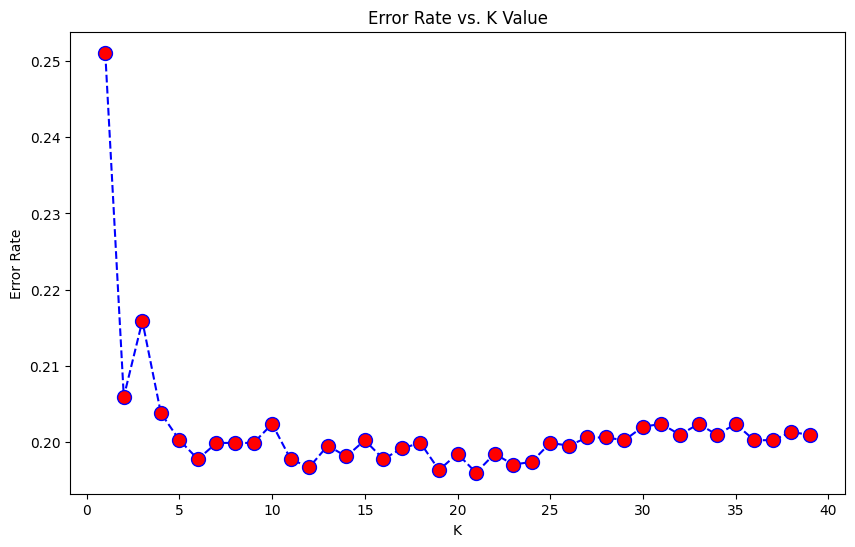

In [56]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [57]:
# NOW WITH K=6
knn = KNeighborsClassifier(n_neighbors=6)

knn.fit(X_train,y_train)
pred = knn.predict(X_test)

accuracy_knn = knn.score(X_test,y_test)
print("KNN accuracy:",accuracy_knn)
print('WITH K=6')
print('\n')
print(confusion_matrix(y_test,pred))
print('\n')
print(classification_report(y_test,pred))

KNN accuracy: 0.8022017045454546
WITH K=6


[[2148   78]
 [ 479  111]]


              precision    recall  f1-score   support

           0       0.82      0.96      0.89      2226
           1       0.59      0.19      0.28       590

    accuracy                           0.80      2816
   macro avg       0.70      0.58      0.59      2816
weighted avg       0.77      0.80      0.76      2816



In [58]:
# Random forest
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

predictions_rf = rf_model.predict(X_test)
accuracy_rf = rf_model.score(X_test,y_test)
print("Random Forest accuracy:",accuracy_rf)
print(confusion_matrix(y_test,predictions_rf))
print(classification_report(y_test,predictions_rf))

# Fetch importance
importances = rf_model.feature_importances_
feature_importances = {feature: importance for feature, importance in zip(features, importances)}

# Sorted feature importance
sorted_features = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)
for feature, importance in sorted_features:
    print(f"Feature: {feature}, Importance: {importance}")

Random Forest accuracy: 0.8558238636363636
[[2147   79]
 [ 327  263]]
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      2226
           1       0.77      0.45      0.56       590

    accuracy                           0.86      2816
   macro avg       0.82      0.71      0.74      2816
weighted avg       0.85      0.86      0.84      2816

Feature: t1_MAFLD, Importance: 0.053184249680480224
Feature: t2_waist_y, Importance: 0.05154304601667186
Feature: t2_BMI, Importance: 0.051282938255134816
Feature: t1_BMI, Importance: 0.04776764086196713
Feature: t1_waist_y, Importance: 0.03740086556478868
Feature: t2_gamgt, Importance: 0.0267872170880632
Feature: t2_Triglyceride_y, Importance: 0.024539130398117573
Feature: t1_Triglyceride_y, Importance: 0.023489641386221765
Feature: t1_gamgt, Importance: 0.02219627839841366
Feature: t2_MAFLD, Importance: 0.021691595513771575
Feature: t2_ALT_GPT, Importance: 0.017458612297816388
Feature: t1_Insul

In [32]:
# TODO:
# Need do scaling
# Need add cross-validation

from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Resolve the log model cannot converge issue
# Standarize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=101)

#Logistic Regression
logmodel = LogisticRegression(max_iter = 2000)
logmodel.fit(X_train,y_train)

# Evaluation
predictions_log = logmodel.predict(X_test)
print(classification_report(y_test,predictions_log))

#Coef and intercept
print(logmodel.coef_, logmodel.intercept_)

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      2229
           1       0.73      0.47      0.57       587

    accuracy                           0.85      2816
   macro avg       0.80      0.71      0.74      2816
weighted avg       0.84      0.85      0.84      2816

[[-4.13166796e-02  1.00198095e+00  2.20929605e-01 -9.14122733e-02
  -9.21312105e-02 -4.22472211e-01 -2.48782430e-02 -2.71914020e-02
   7.19073529e-02  4.63833759e-02  7.20510768e-01 -8.25475611e-01
  -2.36616339e-01  4.27569393e-01 -1.83448607e-01 -1.86992261e-02
   8.08036168e-02  5.90176787e-02  1.25376602e-02 -7.33692895e-02
  -1.50275010e-01  1.17170865e-01  4.64648164e-02 -1.06806644e-02
   6.35771656e-02  1.05343572e-01  4.32779557e-03 -1.98379717e-01
   4.62573301e-02 -7.03997020e-02 -7.84382936e-02  5.67748924e-02
   3.92567457e-02 -1.54726532e-02 -9.63779187e-03  1.29383986e-01
   6.40123617e-04  6.96249134e-03 -7.99656617e-02 -2.49608499e-02
   5.04699262

In [57]:
#

In [ ]:
# for column in df7.columns:
#     if df7[column].dtype == object:  # 检查列的数据类型是否为对象（字符串）
#         non_numeric_values = df7[column].apply(lambda x: not x.isnumeric() if isinstance(x, str) else False)
#         if non_numeric_values.any():
#             print(f"Column '{column}' contains non-numeric values:")
#             print(df7[column][non_numeric_values])
#             print()